# Generate results using the ground truth and predictions

In [1]:
import os
import json
import numpy as np
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    accuracy_score,
    f1_score
)
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

### Static

In [2]:
DEPLOYMENT_GPT_4o_MINI = "Checklist-GPT-4o-mini"
DEPLOYMENT_GPT_4o = "Checklist-GPT-4o-20112024"
DEPLOYMENT_GPT_o3_MINI = "Checklist-GPT-o3-mini"
DEPLOYMENT_GPT_41 = "Checklist-GPT-4.1"

GROUND_TRUTH_FOLDER = "review-5k-dataset/300/"
LLM_RESPONSES_FOLDER = "LLM_Responses_Parsed"

### Helper Functions

In [3]:
def get_100_sampled_papers():

    with open('100_sampled_paper_ids.txt', 'r') as file:
        paper_ids = file.read().splitlines()

    # Add .json to each paper ID
    json_filenames = [paper_id + '.json' for paper_id in paper_ids]

    return json_filenames

def load_json_file(json_file):
    with open(json_file, 'r') as file:
        data = json.load(file)
    return data

def load_ground_truths():
    ground_truth_files = get_100_sampled_papers()
    ground_truths = {}
    for file in ground_truth_files:
        file_path = os.path.join(GROUND_TRUTH_FOLDER, file)
        json_data = load_json_file(file_path)
        decision = json_data["decision"]
        if "accept" in decision.lower():
            decision = "accept"
        else:
            decision = "reject"
        
        ground_truths[file] = {
            "rates": json_data["rates"],
            "decision": decision
            }
        
    return ground_truths

def load_predictions(deloyment):
    predictions_path = os.path.join(LLM_RESPONSES_FOLDER, deloyment)
    prediction_files = os.listdir(predictions_path)
    if ".DS_Store" in prediction_files:
        prediction_files.remove(".DS_Store")

    predictions = {}
    for file in prediction_files:
        file_path = os.path.join(LLM_RESPONSES_FOLDER, deloyment, file)
        json_data = load_json_file(file_path)
        reviews = json_data["reviews"]
        decision = json_data["decision"]
        ratings = [item['rating'] for item in reviews]
        predictions[file] = {
            "rates": ratings,
            "decision": decision
        }

    return predictions

### Scoring Functions

In [4]:
def compute_reviewer_n_minus_1_mae_mse_r2(ground_truth, predictions):
    
    # Step-1:
    mses = []
    maes = []
    list_of_n_minus_1_mean_human_ratings_duplicated = []
    list_of_llm_ratings_duplicated = []
    for paper_id, paper_dict in ground_truth.items():
        
        llm_ratings = np.array(predictions[paper_id]["rates"])
        
        human_ratings = ground_truth[paper_id]["rates"]
        n_minus_1_mean_human_ratings = []
        for h_r in human_ratings:
            n_minus_1_mean_human_ratings.append((np.sum(human_ratings)- h_r)/(len(human_ratings)-1))
            
        llm_ratings_duplicated = np.tile(llm_ratings, len(n_minus_1_mean_human_ratings))
        n_minus_1_mean_human_ratings_duplicated = np.tile(n_minus_1_mean_human_ratings, len(llm_ratings))
        
        mses.append(mean_squared_error(n_minus_1_mean_human_ratings_duplicated, llm_ratings_duplicated))
        maes.append(mean_absolute_error(n_minus_1_mean_human_ratings_duplicated, llm_ratings_duplicated))
        
        list_of_n_minus_1_mean_human_ratings_duplicated.extend(n_minus_1_mean_human_ratings_duplicated)
        list_of_llm_ratings_duplicated.extend(llm_ratings_duplicated)

    # Step-2:
    mae = round(np.mean(maes), 2)
    mse = round(np.mean(mses), 2)
    r2 = round(r2_score(list_of_n_minus_1_mean_human_ratings_duplicated, list_of_llm_ratings_duplicated), 2)
    return {
        "MAE": mae,
        "MSE": mse,
        "R2": r2
    }

def compute_llm_reviewer_n_mae_mse_r2(ground_truth, predictions):

    # Step-1:
    mses = []
    maes = []
    list_of_mean_human_ratings = []
    list_of_llm_ratings = []
    for paper_id, paper_dict in ground_truth.items():
        
        llm_ratings = np.array(predictions[paper_id]["rates"])
        mean_human_rating = np.mean(ground_truth[paper_id]["rates"])
        mean_human_ratings = [mean_human_rating for _ in llm_ratings]
        mses.append(mean_squared_error(mean_human_ratings, llm_ratings))
        maes.append(mean_absolute_error(mean_human_ratings, llm_ratings))
        list_of_mean_human_ratings.extend(mean_human_ratings)
        list_of_llm_ratings.extend(llm_ratings)

    # Step-2:
    mae = round(np.mean(maes), 2)
    mse = round(np.mean(mses), 2)
    r2 = round(r2_score(list_of_mean_human_ratings, list_of_llm_ratings), 2)
    return {
        "MAE": mae,
        "MSE": mse,
        "R2": r2
    }

def compute_accuracy_and_f1(ground_truth, predictions):
    
    # Step-1: Prepare true decisions and predicted decisions
    true_decisions = []
    pred_decisions = []
    for paper_id in ground_truth:
        true_decisions.append(ground_truth[paper_id]["decision"])
        pred_decisions.append(predictions[paper_id]["decision"])

    # Compute Accuracy and Macro F1 as percentages
    acc = round(accuracy_score(true_decisions, pred_decisions) * 100, 2)
    f1 = round(f1_score(true_decisions, pred_decisions, average='macro') * 100, 2)

    return {
        "accuracy": acc,
        "f1_score": f1
    }
    
def compute_accuracy_and_f1_from_score(ground_truth, predictions):
    
    # Step-1:
    accs = []
    f1s = []
    for paper_id in ground_truth:
        true_decision = (ground_truth[paper_id]["decision"] == 'accept')
        pred_decisions = np.array(predictions[paper_id]["rates"]) > 5
        
        true_decisions = [true_decision for _ in pred_decisions]
        
        accs.append(accuracy_score(true_decisions, pred_decisions) * 100)
        
        # I put Micro here because I'm calcuting for 1 paper, np.mean() will be computed later to get Macro F1
        f1s.append(f1_score(true_decisions, pred_decisions, average='micro')*100)
        

    # Step-2
    acc = round(np.mean(accs), 2)
    f1 = round(np.mean(f1s), 2)

    return {
        "accuracy": acc,
        "f1_score": f1
    }

### Get Predictions

In [5]:
ground_truths = load_ground_truths()
predictions_4o = load_predictions(DEPLOYMENT_GPT_4o)
predictions_4o_mini = load_predictions(DEPLOYMENT_GPT_4o_MINI)
predictions_41 = load_predictions(DEPLOYMENT_GPT_41)
predictions_o3_mini = load_predictions(DEPLOYMENT_GPT_o3_MINI)

### Compute scores

In [6]:
# n-1 MAE, MSE, R2
expert = compute_reviewer_n_minus_1_mae_mse_r2(ground_truths, ground_truths)
n_minus_1_4o = compute_reviewer_n_minus_1_mae_mse_r2(ground_truths, predictions_4o)
n_minus_1_4o_mini = compute_reviewer_n_minus_1_mae_mse_r2(ground_truths, predictions_4o_mini)
n_minus_1_41 = compute_reviewer_n_minus_1_mae_mse_r2(ground_truths, predictions_41)
n_minus_1_o3_mini = compute_reviewer_n_minus_1_mae_mse_r2(ground_truths, predictions_o3_mini)

# n MAE, MSE, R2
n_4o = compute_llm_reviewer_n_mae_mse_r2(ground_truths, predictions_4o)
n_4o_mini = compute_llm_reviewer_n_mae_mse_r2(ground_truths, predictions_4o_mini)
n_41 = compute_llm_reviewer_n_mae_mse_r2(ground_truths, predictions_41)
n_o3_mini = compute_llm_reviewer_n_mae_mse_r2(ground_truths, predictions_o3_mini)

# Accuracy, Macro F1
expert_acc_f1_by_score = compute_accuracy_and_f1_from_score(ground_truths, ground_truths)
af_4o_by_score = compute_accuracy_and_f1_from_score(ground_truths, predictions_4o)
af_4o_mini_by_score = compute_accuracy_and_f1_from_score(ground_truths, predictions_4o_mini)
af_41_by_score = compute_accuracy_and_f1_from_score(ground_truths, predictions_41)
af_o3_mini_by_score = compute_accuracy_and_f1_from_score(ground_truths, predictions_o3_mini)


af_4o = compute_accuracy_and_f1(ground_truths, predictions_4o)
af_4o_mini = compute_accuracy_and_f1(ground_truths, predictions_4o_mini)
af_41 = compute_accuracy_and_f1(ground_truths, predictions_41)
af_o3_mini = compute_accuracy_and_f1(ground_truths, predictions_o3_mini)


In [7]:
markdown = f"""
***
# Results
***

#### **Original Results (from paper)**
| Method             | Proxy(n-1) MAE | Proxy(n-1) MSE | Proxy(n) MAE | Proxy(n) MSE   | Accuracy | Macro F1 |
|--------------------|----------------|----------------|---------------|---------------|----------|----------|
| Expert  Individual |      1.16      |      2.34      |       -       |       -       | 75.40%   | 75.39%   |
| GPT 4o             |      2.24      |      6.61      |     2.30      |      6.53     | 52.58%   | 34.51%   |
| GPT 4o Mini        |      1.53      |      3.44      |     1.40      |      2.98     | 53.06%   | 34.72%   |


#### **Computed Results with 300 papers**
| Method             | Proxy(n-1) MAE | Proxy(n-1) MSE | Proxy(n-1) $R^2$ | Proxy(n) MAE  | Proxy(n) MSE  | Proxy(n) $R^2$ | Accuracy (score>5) | Macro F1 (score>5) | Accuracy (predicted "decision") | Macro F1 (predicted "decision") |
|--------------------|----------------|----------------|------------------|---------------|---------------|----------------|----------|----------|----------|----------|
| Expert  Individual |{expert['MAE']} | {expert['MSE']}|{expert['R2']}    |       -       |       -       |       -        |{expert_acc_f1_by_score['accuracy']}%|{expert_acc_f1_by_score['f1_score']}%| - | - |
| GPT 4o             |{n_minus_1_4o['MAE']}|{n_minus_1_4o['MSE']}|{n_minus_1_4o['R2']}|{n_4o['MAE']}|{n_4o['MSE']}|{n_4o['R2']}|{af_4o_by_score['accuracy']}%|{af_4o_by_score['f1_score']}%|{af_4o['accuracy']}%|{af_4o['f1_score']}%|
| GPT 4o Mini        |{n_minus_1_4o_mini['MAE']}|{n_minus_1_4o_mini['MSE']}|{n_minus_1_4o_mini['R2']}|  {n_4o_mini['MAE']}|{n_4o_mini['MSE']}|{n_4o_mini['R2']} | {af_4o_mini_by_score['accuracy']}%|{af_4o_mini_by_score['f1_score']}%| {af_4o['accuracy']}%|{af_4o['f1_score']}%|
| GPT 4.1            |{n_minus_1_41['MAE']}|{n_minus_1_41['MSE']}|{n_minus_1_41['R2']}|  {n_41['MAE']}|{n_41['MSE']}|{n_41['R2']} | {af_41_by_score['accuracy']}%|{af_41_by_score['f1_score']}%| {af_41['accuracy']}%|{af_41['f1_score']}%|
| GPT o3 Mini        |{n_minus_1_o3_mini['MAE']}|{n_minus_1_o3_mini['MSE']}|{n_minus_1_o3_mini['R2']}|  {n_o3_mini['MAE']}|{n_o3_mini['MSE']}|{n_o3_mini['R2']} | {af_o3_mini_by_score['accuracy']}%|{af_o3_mini_by_score['f1_score']}%| {af_o3_mini['accuracy']}%|{af_o3_mini['f1_score']}%|
"""

with open("final_results.md", 'w+') as f:
    f.write(markdown)

In [8]:
from IPython.display import Markdown, display

display(Markdown("final_results.md"))


***
# Results
***

#### **Original Results (from paper)**
| Method             | Proxy(n-1) MAE | Proxy(n-1) MSE | Proxy(n) MAE | Proxy(n) MSE   | Accuracy | Macro F1 |
|--------------------|----------------|----------------|---------------|---------------|----------|----------|
| Expert  Individual |      1.16      |      2.34      |       -       |       -       | 75.40%   | 75.39%   |
| GPT 4o             |      2.24      |      6.61      |     2.30      |      6.53     | 52.58%   | 34.51%   |
| GPT 4o Mini        |      1.53      |      3.44      |     1.40      |      2.98     | 53.06%   | 34.72%   |


#### **Computed Results with 300 papers**
| Method             | Proxy(n-1) MAE | Proxy(n-1) MSE | Proxy(n-1) $R^2$ | Proxy(n) MAE  | Proxy(n) MSE  | Proxy(n) $R^2$ | Accuracy (score>5) | Macro F1 (score>5) | Accuracy (predicted "decision") | Macro F1 (predicted "decision") |
|--------------------|----------------|----------------|------------------|---------------|---------------|----------------|----------|----------|----------|----------|
| Expert  Individual |1.25 | 2.54|-1.02    |       -       |       -       |       -        |77.3%|77.3%| - | - |
| GPT 4o             |2.02|5.48|-3.16|2.0|5.32|-3.52|50.25%|50.25%|51.0%|35.52%|
| GPT 4o Mini        |2.38|7.18|-4.44|  2.37|7.08|-5.02 | 50.0%|50.0%| 51.0%|35.52%|
| GPT 4.1            |2.28|6.66|-4.04|  2.27|6.5|-4.53 | 50.0%|50.0%| 50.0%|33.33%|
| GPT o3 Mini        |2.24|6.54|-3.95|  2.23|6.38|-4.43 | 50.0%|50.0%| 50.0%|33.33%|


### Visualization


In [25]:
def plot_groundtruth_vs_predictions_ratings(ground_truths, predictions):
    """
    Scatter plot of ground truth vs. predictions for multiple models.

    Parameters:
    - ground_truths: list or array-like, the same for all models
    - predictions: dict of {model_name: list/array of predicted values}
    """

    # Build a DataFrame with one row per prediction, model, and corresponding ground truth
    data = []
    for model_name, preds in predictions.items():
        for gt, pred in zip(ground_truths, preds):
            data.append({"ground_truth": gt, "prediction": pred, "model": model_name})

    df_long = pd.DataFrame(data)

    # Plot
    plt.figure(figsize=(10, 6))
    for model in df_long['model'].unique():
        model_data = df_long[df_long['model'] == model]
        plt.scatter(model_data['ground_truth'], model_data['prediction'], label=model, alpha=0.6)

    plt.xlabel("Ground Truth rating")
    plt.ylabel("Predicted rating")
    plt.title("Ground Truth vs. Model Predictions")
    plt.legend(title="Model")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_accept_reject_counts(predictions):
    """
    Bar plot showing count of accept (1) and reject (0) decisions per model.

    Parameters:
    - predictions: dict of {model_name: list of 0s and 1s}
    """

    # Build list of rows: model name and decision (0 or 1)
    data = []
    for model_name, preds in predictions.items():
        for decision in preds:
            data.append({
                "model": model_name,
                "decision": "accept" if decision == 1 else "reject"
            })

    df = pd.DataFrame(data)

    # Count number of accept/reject per model
    summary = df.groupby(["model", "decision"]).size().reset_index(name="count")
    print(summary)

    # Define custom color palette
    palette = {
        "accept": "#4CAF50",  # green
        "reject": "#F44336"   # red
    }

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=summary, x="model", y="count", hue="decision",
        width=0.5, palette=palette
    )
    plt.title("Accept/Reject Counts per Model")
    plt.xlabel("Model")
    plt.ylabel("Count")
    plt.legend(title="Decision")
    plt.tight_layout()
    plt.show()

In [10]:
def get_mean_rating_and_decision(reviews_dict):
    papers_100 = get_100_sampled_papers()
    ratings, decisions = [], []
    for paper in papers_100:
        ratings.append(np.mean(reviews_dict[paper]["rates"]))
        decisions.append(1 if reviews_dict[paper]["decision"] == 'accept' else 0)
    
    return {
        "ratings": ratings,
        "decisions": decisions
    }

In [11]:
rating_decisions_expert = get_mean_rating_and_decision(ground_truths)
rating_decisions_4o = get_mean_rating_and_decision(predictions_4o)
rating_decisions_4o_mini = get_mean_rating_and_decision(predictions_4o_mini)
rating_decisions_41 = get_mean_rating_and_decision(predictions_41)
rating_decisions_o3_mini = get_mean_rating_and_decision(predictions_o3_mini)

#### Ratings plot

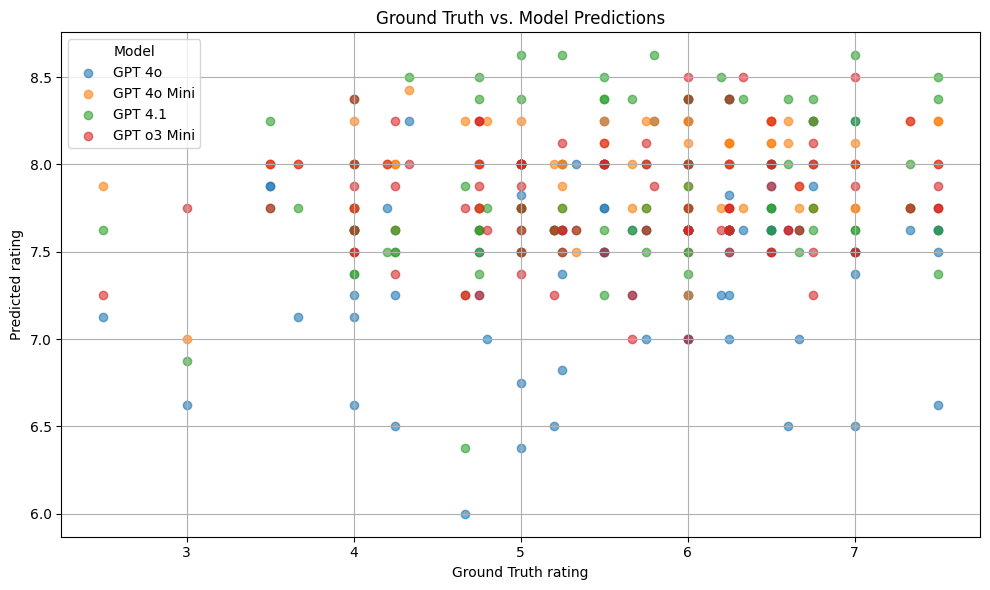

In [12]:
models_dict_ratings = {
    "GPT 4o": rating_decisions_4o["ratings"],
    "GPT 4o Mini": rating_decisions_4o_mini["ratings"],
    "GPT 4.1": rating_decisions_41["ratings"],
    "GPT o3 Mini": rating_decisions_o3_mini["ratings"]
}

plot_groundtruth_vs_predictions_ratings(rating_decisions_expert["ratings"], models_dict_ratings)

#### Decisions plot

          model decision  count
0       GPT 4.1   accept    100
1        GPT 4o   accept     99
2        GPT 4o   reject      1
3   GPT 4o Mini   accept    100
4   GPT o3 Mini   accept    100
5  Ground Truth   accept     50
6  Ground Truth   reject     50


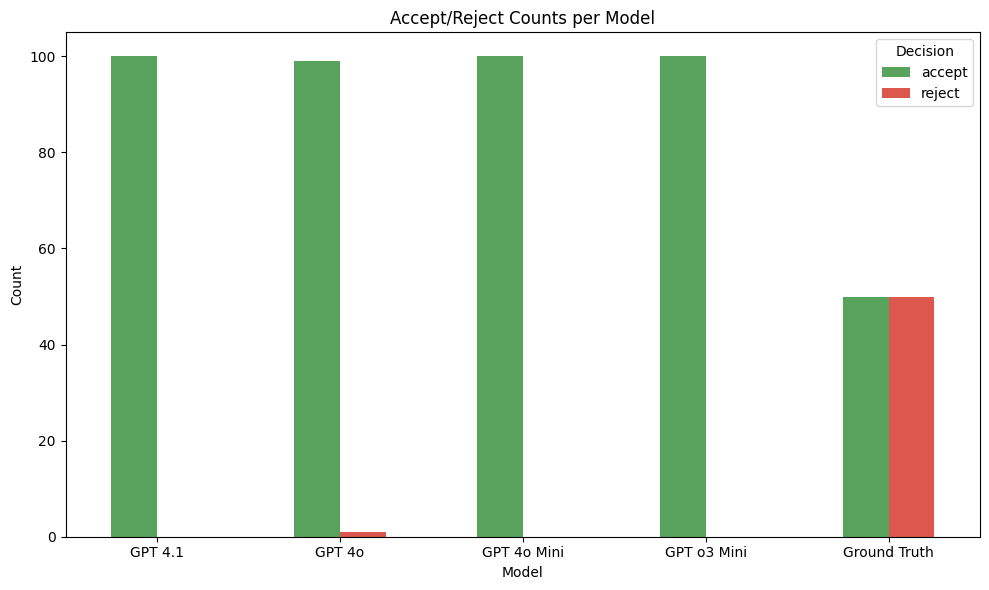

In [26]:
models_dict_decisions = {
    "Ground Truth": rating_decisions_expert["decisions"],
    "GPT 4o": rating_decisions_4o["decisions"],
    "GPT 4o Mini": rating_decisions_4o_mini["decisions"],
    "GPT 4.1": rating_decisions_41["decisions"],
    "GPT o3 Mini": rating_decisions_o3_mini["decisions"]
}

plot_accept_reject_counts(models_dict_decisions)